In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!ls

!ls resized_images | wc -l

bobross       BobRossGAN.ipynb	generated_images
bobross2.zip  GAN_weights	resized_images
2612


# Importing Libraries

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np

In [3]:
cd 'drive/MyDrive/GANS Course/Bob Ross Generator'

/content/drive/MyDrive/GANS Course/Bob Ross Generator


In [5]:
!pwd

/content/drive/MyDrive/GANS Course/Bob Ross Generator


# Setting up and formatting images

In [6]:
#!unzip bobross2.zip -d bobross

In [4]:
images_path = "/content/drive/MyDrive/GANS Course/Bob Ross Generator/bobross/bobross2/"

In [8]:
!mkdir resized_images
!ls

mkdir: cannot create directory ‘resized_images’: File exists
bobross       BobRossGAN.ipynb	generated_images
bobross2.zip  GAN_weights	resized_images


In [5]:
import os
import cv2

In [10]:

#reshape_size = (64, 64)

#i = 0
#for image in os.listdir(images_path):
#  print(image)
#  img = cv2.imread(images_path + image)
 # img = cv2.resize(img, reshape_size)
 # cv2.imwrite("resized_images/%d.png" % i, img)
 # i += 1

In [11]:
#!ls resized_images/

# Parameters for NN and Data

In [6]:
img_width = 64
img_height = 64
channels = 3
img_shape = (img_width, img_height, channels)
latent_dim = 100
adam_0001 = Adam(lr=0.0001)
adam_0004 = Adam(lr=0.0004)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Building Generator

In [7]:
def build_generator():
  model = Sequential()
  model.add(Dense(256 * 8 * 8, input_dim = latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((8, 8, 256)))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (3,3), activation='tanh', padding = 'same'))

  model.summary()
  return model

generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      262272    
 ranspose)                                              

# Building Discriminator

In [9]:
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(64, (3,3), padding='same', input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Conv2D(256, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  model.summary()
  return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam_0004, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 256)      

# Connecting Neural Networks to build GAN

In [10]:
def build_GAN(generator_mod, discriminator_mod):
  GAN = Sequential()
  discriminator_mod.trainable = False
  GAN.add(generator_mod)
  GAN.add(discriminator_mod)
  GAN.summary()
  GAN.compile(loss = 'binary_crossentropy', optimizer = adam_0001)
  return GAN

GAN = build_GAN(generator, discriminator)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         2707203   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 1566977   
                                                                 
Total params: 4,274,180
Trainable params: 2,707,203
Non-trainable params: 1,566,977
_________________________________________________________________


In [11]:
!pwd
# Loading existing GAN weights
generator = load_model('GAN_weights/gen_0.00000250_weights')
discriminator = load_model('GAN_weights/dis_0.00000250_weights')
GAN = build_GAN(generator, discriminator)

/content/drive/MyDrive/GANS Course/Bob Ross Generator
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         2707203   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1566977   
                                                                 
Total params: 4,274,180
Trainable params: 2,707,203
Non-trainable params: 1,566,977
_________________________________________________________________


# Outputting Images

In [12]:
import matplotlib.pyplot as plt
import glob
import imageio
import PIL

save_name = 0.00000250

def save_imgs():
  r, c = 3, 3
  noise = np.random.normal(0, 1, (r * c, latent_dim))
  gen_imgs = generator.predict(noise)
  global save_name
  save_name += 0.00000010

  gen_imgs = (gen_imgs + 1) / 2

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt])
      axs[i,j].axis('off')
      cnt += 1
  fig.savefig("generated_images/%.8f.png" % save_name)
  plt.close()


In [18]:
!mkdir generated_images
!ls

mkdir: cannot create directory ‘generated_images’: File exists
bobross       BobRossGAN.ipynb	generated_images
bobross2.zip  GAN_weights	resized_images


# Training GAN

In [13]:
def normalise_image_data(im_data):
  return (im_data / 127.5) - 1

In [14]:
from PIL import Image

In [24]:
!ls resized_images | head

0.png
1000.png
1001.png
1002.png
1003.png
1004.png
1005.png
1006.png
1007.png
1008.png


In [18]:
array = []
path = 'resized_images/'

for image in os.listdir(path):
  print(image)
  image = Image.open(path + image)
  data = np.asarray(image)
  array.append(data)

X_train = np.array(array)
X_train = normalise_image_data(X_train)
print(X_train.shape)

86.png
88.png
87.png
89.png
90.png
91.png
92.png
94.png
93.png
95.png
96.png
97.png
98.png
99.png
100.png
101.png
103.png
102.png
104.png
105.png
106.png
107.png
108.png
109.png
110.png
111.png
113.png
112.png
114.png
115.png
116.png
117.png
118.png
119.png
120.png
121.png
122.png
123.png
124.png
126.png
125.png
128.png
127.png
129.png
130.png
131.png
132.png
133.png
134.png
135.png
136.png
137.png
139.png
138.png
141.png
140.png
142.png
143.png
144.png
145.png
146.png
148.png
147.png
149.png
150.png
151.png
152.png
153.png
155.png
154.png
157.png
156.png
158.png
159.png
160.png
161.png
162.png
163.png
164.png
165.png
166.png
167.png
168.png
169.png
170.png
172.png
171.png
173.png
174.png
175.png
176.png
177.png
178.png
179.png
180.png
181.png
182.png
183.png
185.png
184.png
187.png
186.png
189.png
188.png
190.png
191.png
192.png
193.png
194.png
195.png
196.png
197.png
198.png
200.png
199.png
202.png
201.png
203.png
204.png
205.png
207.png
206.png
208.png
209.png
211.png
210.png
212.pn

In [15]:
valid = np.ones((10, 1)) - 0.1
valid

array([[0.9],
       [0.9],
       [0.9],
       [0.9],
       [0.9],
       [0.9],
       [0.9],
       [0.9],
       [0.9],
       [0.9]])

In [28]:
def train(X_train ,epochs, batch_size=64):
  print(X_train.shape)

  #Rescaling data
  batches_per_epo = int(X_train.shape[0] / batch_size)

  #Create Y
  valid = np.ones((batch_size, 1)) - 0.1
  fakes = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    for j in range(batches_per_epo):
      # Get random batch
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]

      # Generate fake images
      noise = np.random.normal(0, 1, (batch_size, latent_dim))
      gen_imgs = generator.predict(noise)

      # Train discriminator
      d_loss_real = discriminator.train_on_batch(imgs, valid)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      noise = np.random.normal(0, 1, (batch_size, latent_dim))

      #inverse y label
      g_loss = GAN.train_on_batch(noise, valid)

      print("Epoch: %d.%d [D loss: %f, acc: %.2f%%] [G loss: %f]" % (epoch, j, d_loss[0], 100 * d_loss[1], g_loss))
    if (epoch % 10 == 0):
      save_imgs()
      discriminator.save("GAN_weights/dis_%.8f_weights" % save_name)
      generator.save("GAN_weights/gen_%.8f_weights" % save_name)

train(X_train, 500, batch_size = 24)

Streaming output truncated to the last 5000 lines.
Epoch: 50.33 [D loss: 1.495404, acc: 0.00%] [G loss: 0.328569]
Epoch: 50.34 [D loss: 1.351813, acc: 0.00%] [G loss: 0.331076]
Epoch: 50.35 [D loss: 1.357883, acc: 0.00%] [G loss: 0.329101]
Epoch: 50.36 [D loss: 1.418420, acc: 0.00%] [G loss: 0.329446]
Epoch: 50.37 [D loss: 1.367124, acc: 0.00%] [G loss: 0.329775]
Epoch: 50.38 [D loss: 1.379764, acc: 0.00%] [G loss: 0.331238]
Epoch: 50.39 [D loss: 1.425422, acc: 0.00%] [G loss: 0.329227]
Epoch: 50.40 [D loss: 1.426207, acc: 0.00%] [G loss: 0.328148]
Epoch: 50.41 [D loss: 1.422890, acc: 0.00%] [G loss: 0.329293]
Epoch: 50.42 [D loss: 1.407373, acc: 0.00%] [G loss: 0.328505]
Epoch: 50.43 [D loss: 1.389607, acc: 0.00%] [G loss: 0.326691]
Epoch: 50.44 [D loss: 1.309667, acc: 0.00%] [G loss: 0.328540]
Epoch: 50.45 [D loss: 1.350544, acc: 0.00%] [G loss: 0.327943]
Epoch: 50.46 [D loss: 1.367547, acc: 0.00%] [G loss: 0.329746]
Epoch: 50.47 [D loss: 1.374766, acc: 0.00%] [G loss: 0.328993]
Epoc

KeyboardInterrupt: ignored

In [16]:
noise = np.random.normal(0, 1, (16, latent_dim))
gen_imgs = generator.predict(noise)
gen_imgs_1 = (gen_imgs + 1) / 2.0
gen_imgs_2 = ((gen_imgs + 1) * 127.5)/256 
print(gen_imgs_1[0][0][0]) 
print(gen_imgs_2[0][0][0])

[0.17909607 0.1505473  0.20603749]
[0.17839648 0.14995922 0.20523266]


# GAN Results: Generated vs Real

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Real Image')

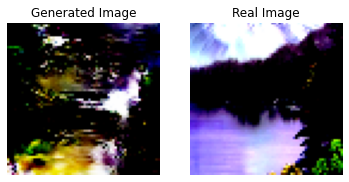

In [31]:
noise = np.random.normal(0, 1, (16, latent_dim))
gen_imgs = generator.predict(noise)
random_real = np.random.randint(0,2612)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(gen_imgs[1])
axs[1].imshow(X_train[random_real])
axs[0].axis('off')
axs[0].set_title('Generated Image')
axs[1].axis('off')
axs[1].set_title('Real Image')